# Import Libraries

In [1]:
import numpy as np
import random 
import time
import statistics
import pandas as pd 
import pickle

import matplotlib.pyplot as plt 

from keras.models import Sequential  
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load Data, View, and Format

In [2]:
data_train = np.load('kmnist-train-imgs.npz')
labels_train = np.load('kmnist-train-labels.npz')
data_test = np.load('kmnist-test-imgs.npz')
labels_test = np.load('kmnist-test-labels.npz')

In [4]:
k_train_samples = data_train['arr_0']
k_train_labels = labels_train['arr_0']
k_test_samples = data_test['arr_0']
k_test_labels = labels_test['arr_0']

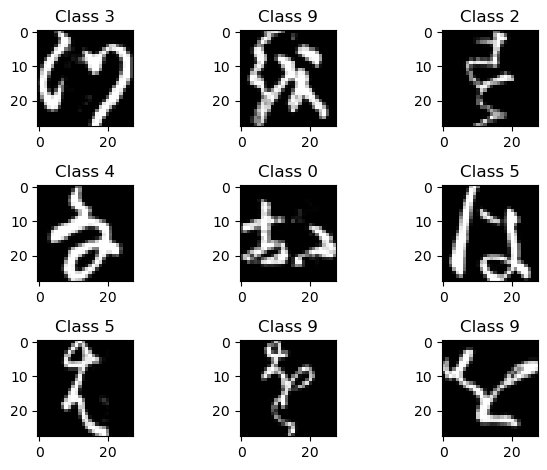

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(k_train_samples))
    plt.imshow(k_train_samples[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(k_train_labels[num]))
    
plt.tight_layout()

In [6]:
X_train = k_train_samples.reshape(60000, 784) 
X_test = k_test_samples.reshape(10000, 784)   

X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                        
X_test /= 255

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [7]:
no_classes = 10

Y_train = utils.to_categorical(k_train_labels, no_classes)
Y_test = utils.to_categorical(k_test_labels, no_classes)

# Create Hyperparameter Distributions

In [8]:
# Hyperparameters

#layer_widths = np.random.randint(1,100,20)
#layer_heights = np.random.randint(1,10,20)
#learning_rates = np.clip(np.random.exponential(scale=1,size=20),0,1)
#momentums = np.clip(np.random.exponential(scale=1,size=20),0,1)
#optimizer_choice = np.zeros(20)
#for i in range(optimizer_choice.shape[0]):
   # optimizer_choice[i] = random.randint(0, 1)
#print(optimizer_choice)
#trial = 0

## Making the Different CNN's to Test Out

In [11]:
t0 = time.time()
best_models = []
best_histories = []
best_accuracies = []
best_loss = []
best_lrs = []
best_ms = []
best_widths = []
best_heights = []
best_batch_sizes = []
best_conv_heights = []
best_conv_filters = []
best_scores = []

num_tries_per_trial = 3
num_trials = 20

for trial in range(1,1+num_trials): 
    t0_trial = time.time()
    
    # Hyperparameters
    layer_widths = np.random.randint(5,51,num_tries_per_trial)
    layer_heights = np.random.randint(1,4,num_tries_per_trial)
    learning_rates = np.random.choice(np.array([0.0001, 0.001, 0.01, 0.1, 1]), size=num_tries_per_trial, replace=True)#np.random.randint(1,1000,num_tries_per_trial)/1000 #np.clip(np.random.exponential(scale=1,size=num_tries_per_trial),0,1)
    momentums = np.random.randint(1,10,num_tries_per_trial)/10 #np.clip(np.random.exponential(scale=1,size=num_tries_per_trial),0,1)
    batch_sizes = np.random.choice(np.array([16, 32, 64, 128, 256]), size=num_tries_per_trial, replace=True)
    conv_heights = np.random.randint(1,4,num_tries_per_trial)
    number_filters = np.random.choice(np.array([16, 32, 64, 128, 256]), size=num_tries_per_trial, replace=True)
    
    # Model Construction
    clear_session()
    models = []
    count = 0
    for lw, lh, ch, nf in zip(layer_widths, layer_heights, conv_heights, number_filters):
            model = Sequential()
            for i in range(ch):
                model.add(Conv2D(nf,(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
                model.add(MaxPooling2D((2,2)))
            model.add(Flatten())
            for i in range(lh):
                model.add(Dense(lw, activation='relu', kernel_initializer='he_uniform'))
            model.add(Dense(10, activation='softmax'))
            #model.summary()
            models.append(model)

    # Model Compilation
    for model, lr, m in zip(models, learning_rates, momentums):
        opt = SGD(learning_rate=lr, momentum=m)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Model Training
    callback = EarlyStopping(monitor='loss', patience=1, min_delta=0.5)
    histories = []
    for model, bat_size in zip(models,batch_sizes):
        histories.append( model.fit(X_train, Y_train,
                  batch_size=bat_size, epochs=5,
                  verbose=1,callbacks=[callback]))

    # Identify best model from trial
    find_best_model_in_trial = []
    for history in histories:
        find_best_model_in_trial.append(history.history['loss'][-1])

    index = np.nanargmin(find_best_model_in_trial)
    best_models.append(models[index])
    best_loss.append(histories[index].history['loss'][-1])
    best_histories.append(histories[index])
    best_accuracies.append(histories[index].history['accuracy'][-1])
    best_lrs.append(learning_rates[index])
    best_ms.append(momentums[index])
    best_widths.append(layer_widths[index])
    best_heights.append(layer_heights[index])
    best_batch_sizes.append(batch_sizes[index])
    best_conv_heights.append(conv_heights[index])
    best_conv_filters.append(number_filters[index])
    best_scores.append(models[index].evaluate(X_test, Y_test))

    print("Trial: " + str(trial))
    print("Chosen Model: " + str(index))
    print("Loss: " + str(find_best_model_in_trial[index]))
    print("Training Accuracy: " + str(histories[index].history['accuracy'][-1]))
    print('Test Accuracy: ', best_scores[trial-1][-1])
    print("Learning Rate: " + str(learning_rates[index]))
    print("Momentum: " + str(momentums[index]))
    print("Layer Width: " + str(layer_widths[index]))
    print("Layer Height: " + str(layer_heights[index]))
    print("Batch Size: " + str(batch_sizes[index]))
    print("Convolutional Layer Height: " + str(conv_heights[index]))
    print("Convolutional Layer Filters: " + str(number_filters[index]))
    print()
    t1_trial = time.time()
    print("Trial Time: " + str(t1_trial-t0_trial))
t1 = time.time()

Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 1.5321 - accuracy: 0.4093
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 1.0198 - accuracy: 0.6329
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.7379 - accuracy: 0.7716
Epoch 1/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3939 - accuracy: 0.8794
Epoch 2/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2019 - accuracy: 0.9390
Epoch 1/5
938/938 [==============================] - 24s 25ms/step - loss: 1.0946 - accuracy: 0.6855
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4349 - accuracy: 0.8722
Trial: 1
Chosen Model: 1
Loss: 0.2018817663192749
Training Accuracy: 0.9389500021934509
Test Accuracy:  [0.43489131331443787, 0.8722000122070312]
Learning Rate: 0.01
Momentum: 0.2
Layer Width: 49
Layer Height: 1
Batch Size: 16
Convolutional Layer Height: 1
Convolutional Layer Filters: 32

Trial 

469/469 [==============================] - 126s 267ms/step - loss: 9.0855 - accuracy: 0.0994
Epoch 2/5
469/469 [==============================] - 127s 271ms/step - loss: 2.3061 - accuracy: 0.1009
Epoch 3/5
313/313 [==============================] - 8s 25ms/step - loss: 0.3008 - accuracy: 0.9151
Trial: 15
Chosen Model: 0
Loss: 0.096806101500988
Training Accuracy: 0.9696666598320007
Test Accuracy:  [0.30078068375587463, 0.9150999784469604]
Learning Rate: 0.01
Momentum: 0.6
Layer Width: 24
Layer Height: 2
Batch Size: 16
Convolutional Layer Height: 3
Convolutional Layer Filters: 256

Trial Time: 904.7272064685822
Epoch 1/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.8954 - accuracy: 0.6956
Epoch 2/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4401 - accuracy: 0.8591
Epoch 1/5
469/469 [==============================] - 52s 109ms/step - loss: 1.2426 - accuracy: 0.5748
Epoch 2/5
469/469 [==============================] - 51s 110ms/step - loss: 0

In [15]:
with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models,f)

with open('best_loss.pkl', 'wb') as f:
    pickle.dump(best_loss,f)
    
with open('best_histories.pkl', 'wb') as f:
    pickle.dump(best_histories,f)
    
with open('best_accuracies.pkl', 'wb') as f:
    pickle.dump(best_accuracies,f)
    
with open('best_lrs.pkl', 'wb') as f:
    pickle.dump(best_lrs,f)
    
with open('best_ms.pkl', 'wb') as f:
    pickle.dump(best_ms,f)
    
with open('best_widths.pkl', 'wb') as f:
    pickle.dump(best_widths,f)

with open('best_heights.pkl', 'wb') as f:
    pickle.dump(best_heights,f)
    
with open('best_batch_sizes.pkl', 'wb') as f:
    pickle.dump(best_batch_sizes,f)
    
with open('best_conv_heights.pkl', 'wb') as f:
    pickle.dump(best_conv_heights,f)
    
with open('best_conv_filters.pkl', 'wb') as f:
    pickle.dump(best_conv_filters,f)
    
with open('best_scores.pkl', 'wb') as f:
    pickle.dump(best_scores,f)

In [ ]:
#idx = np.nanargmin(best_loss)
#print("Chosen Trial: " + str(idx+1))
#print("Final Loss: " + str(best_loss[idx]))
#print("Final Accuracy: " + str(best_histories[idx].history['accuracy'][-1]))
#print("Final Learning Rate: " + str(best_lrs[idx]))
#print("Final Momentum: " + str(best_ms[idx]))
#print("Layer Width: " + str(best_widths[idx]))
#print("Layer Height: " + str(best_heights[idx]))
#print()
#print("Total Tuning Time: " + str(t1-t0) + "s")
#print()

In [17]:
# initialize data of lists. 
test_accuracies = []
for score in best_scores:
    test_accuracies.append(score[-1])
data = {'Learning Rate': best_lrs,
        'Momentum:': best_ms,
        'Hidden Layer Width': best_widths,
        'Hidden Layer Height': best_heights,
        'Batch Size': best_batch_sizes,
        'Convolutional Layer Height': best_conv_heights,
        'Convolutional Layer Filters': best_conv_filters,
        'Training Accuracy': best_accuracies, 
        'Testing Accuracy': test_accuracies} 

# Create DataFrame 
df = pd.DataFrame(data) 

with open('dataframe.pkl', 'wb') as f:
    pickle.dump(df,f)
  
# Print the output. 
display(df)
display(df.corr())

,Learning Rate,Momentum:,Hidden Layer Width,Hidden Layer Height,Batch Size,Convolutional Layer Height,Convolutional Layer Filters,Training Accuracy,Testing Accuracy
0,0.0100,0.2,49,1,16,1,32,0.938950,0.8722
1,0.0100,0.5,43,2,256,1,32,0.877600,0.7621
2,0.0010,0.5,27,2,16,1,128,0.912300,0.8350
3,0.1000,0.7,33,1,64,1,32,0.958050,0.8905
4,0.0010,0.6,6,1,32,2,256,0.879283,0.7758
5,0.0100,0.5,14,1,128,2,32,0.829567,0.7219
6,0.1000,0.1,20,1,32,3,16,0.897133,0.8222
7,0.0010,0.9,30,2,256,2,32,0.808933,0.6889
8,0.0010,0.2,41,3,64,1,128,0.884550,0.7691
9,0.0100,0.6,6,3,16,1,16,0.864067,0.7471


,Learning Rate,Momentum:,Hidden Layer Width,Hidden Layer Height,Batch Size,Convolutional Layer Height,Convolutional Layer Filters,Training Accuracy,Testing Accuracy
Learning Rate,1.000000,-0.323486,0.351058,-0.044146,-0.017954,-0.061066,-0.372987,0.461918,0.499798
Momentum:,-0.323486,1.000000,-0.284671,0.067885,0.267989,0.042705,0.119193,-0.125795,-0.140051
Hidden Layer Width,0.351058,-0.284671,1.000000,0.315324,0.264319,-0.292134,-0.230949,0.205435,0.205144
Hidden Layer Height,-0.044146,0.067885,0.315324,1.000000,-0.047683,-0.072509,-0.063604,-0.071176,-0.076111
Batch Size,-0.017954,0.267989,0.264319,-0.047683,1.000000,-0.205731,-0.321861,-0.367934,-0.379185
Convolutional Layer Height,-0.061066,0.042705,-0.292134,-0.072509,-0.205731,1.000000,0.318026,-0.147284,-0.079489
Convolutional Layer Filters,-0.372987,0.119193,-0.230949,-0.063604,-0.321861,0.318026,1.000000,0.105663,0.064882
Training Accuracy,0.461918,-0.125795,0.205435,-0.071176,-0.367934,-0.147284,0.105663,1.000000,0.990179
Testing Accuracy,0.499798,-0.140051,0.205144,-0.076111,-0.379185,-0.079489,0.064882,0.990179,1.000000


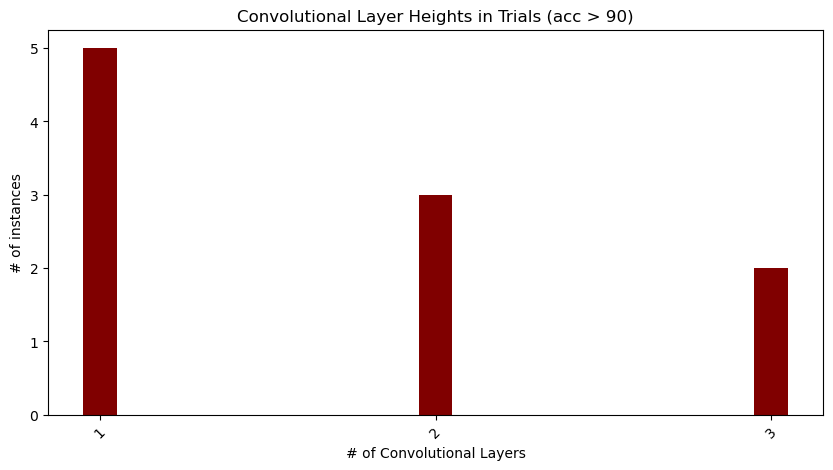

In [48]:
chosen_idx = np.argwhere(np.array(best_accuracies) > 0.90)
#print(chosen_idx)

ab_ch = []
for idx in chosen_idx:
    ab_ch.append(best_conv_heights[idx[0]])


ch_unique, ch_counts = np.unique(ab_ch, return_counts=True)
ch_data = dict(zip(ch_unique, ch_counts))

ch_x_values = list(ch_data.keys())
ch_y_values = list(ch_data.values())
ch_x_values = [str(r) for r in ch_x_values]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(ch_x_values, ch_y_values, color ='maroon', 
        width = 0.1)

 
plt.xlabel("# of Convolutional Layers")
plt.ylabel("# of instances")
plt.title("Convolutional Layer Heights in Trials (acc > 90)")
plt.xticks(ch_x_values,rotation=45)
plt.show()

ch_select = statistics.mode(sorted(ab_ch))

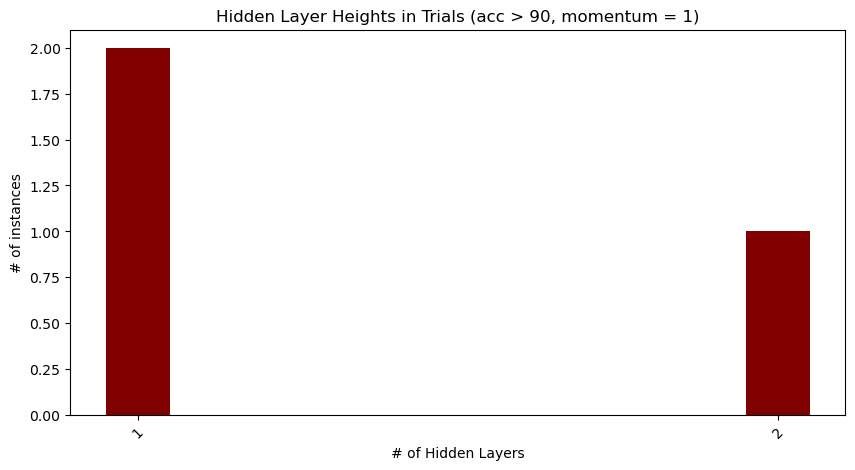

1


In [50]:
former_idx = chosen_idx
chosen_idx = np.argwhere(np.array(best_conv_heights) == ch_select)

chosen_idx = np.nonzero(np.in1d(chosen_idx, former_idx))[0]

ab_hs = []
for idx in chosen_idx:
    ab_hs.append(best_heights[idx])

hs_unique, hs_counts = np.unique(ab_hs, return_counts=True)
hs_data = dict(zip(hs_unique, hs_counts))

h_x_values = list(hs_data.keys())
h_y_values = list(hs_data.values())
h_x_values = [str(r) for r in h_x_values]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(h_x_values, h_y_values, color ='maroon', 
        width = 0.1)

 
plt.xlabel("# of Hidden Layers")
plt.ylabel("# of instances")
plt.title("Hidden Layer Heights in Trials (acc > 90, momentum = 1)")
plt.xticks(h_x_values,rotation=45)
plt.show()

h_select = statistics.mode(sorted(ab_hs))
print(h_select)

In [59]:
former_idx = chosen_idx
chosen_idx = np.argwhere(np.array(best_heights) == h_select)

chosen_idx = np.nonzero(np.in1d(chosen_idx, former_idx))[0]

test_accuracies = []
for score in best_scores:
    test_accuracies.append(score[-1])

#print(best_loss)
idx = chosen_idx[0]
print("Chosen Trial: " + str(idx+1))
print("Final Training Loss: " + str(best_loss[idx]))
print("Final Training Accuracy: " + str(best_histories[idx].history['accuracy'][-1]))
print("Final Testing Accuracy: " + str(test_accuracies[idx]))
print("Final Learning Rate: " + str(best_lrs[idx]))
print("Final Momentum: " + str(best_ms[idx]))
print("Final Hidden Layer Width: " + str(best_widths[idx]))
print("Final Hidden Layer Height: " + str(best_heights[idx]))
print("Final Convolutional Layer Height: " + str(best_conv_heights[idx]))
print("Final Convolutional Layer Filters: " + str(best_conv_filters[idx]))
print("Final Batch Size: " + str(best_batch_sizes[idx]))
print()
 
#ab_lhs = []
#for idx in chosen_idx:
#    ab_lhs.append(best_heights[idx])
#
#lhs_unique, lhs_counts = np.unique(ab_lhs, return_counts=True)
#lhs_data = dict(zip(lhs_unique, lhs_counts))
#
#lh_x_values = list(lhs_data.keys())
#lh_y_values = list(lhs_data.values())
#lh_x_values = [str(r) for r in lh_x_values]
  
#fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
#plt.bar(lh_x_values, lh_y_values, color ='maroon', 
#        width = 0.1)

 
#plt.xlabel("Heights")
#plt.ylabel("# of instances")
#plt.title("Layer Heights in Trials")
#plt.xticks(lh_x_values,rotation=45)
#plt.show()

#lh_select = statistics.mode(sorted(ab_lhs))
#print(lh_select)

#print(lhs_data)

Chosen Trial: 1
Final Training Loss: 0.2018817663192749
Final Training Accuracy: 0.9389500021934509
Final Testing Accuracy: 0.8722000122070312
Final Learning Rate: 0.01
Final Momentum: 0.2
Final Hidden Layer Width: 49
Final Hidden Layer Height: 1
Final Convolutional Layer Height: 1
Final Convolutional Layer Filters: 32
Final Batch Size: 16



In [70]:
# Hyperparameters
layer_widths = best_widths[idx]
layer_heights = best_heights[idx]
learning_rates = best_lrs[idx]
momentums = best_ms[idx]
batch_sizes = best_batch_sizes[idx]
conv_heights = best_conv_heights[idx]
number_filters = best_conv_filters[idx]
    
# Model Construction
clear_session()
count = 0
model = Sequential()
for i in range(conv_heights):
    model.add(Conv2D(number_filters,(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
model.add(Flatten())
for i in range(layer_heights):
    model.add(Dense(layer_widths, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
#model.summary()

# Model Compilation
opt = SGD(learning_rate=learning_rates, momentum=momentums)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.01)
history = model.fit(X_train, Y_train,
                batch_size=batch_sizes, epochs=10,
                verbose=1,callbacks=[callback])


Epoch 1/3
3750/3750 [==============================] - 13s 3ms/step - loss: 0.4141 - accuracy: 0.8741
Epoch 2/3
3750/3750 [==============================] - 13s 3ms/step - loss: 0.1903 - accuracy: 0.9441
Epoch 3/3
3750/3750 [==============================] - 13s 3ms/step - loss: 0.1321 - accuracy: 0.9625


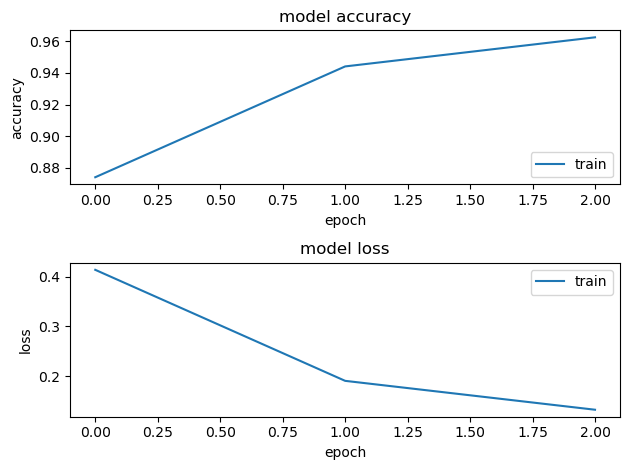

In [71]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [72]:
scores = model.evaluate(X_test, Y_test)
print("Test Accuracy: ", scores[-1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3230 - accuracy: 0.9063
Test Accuracy:  0.9063000082969666


313/313 [==============================] - 1s 2ms/step
Accuracy: 0.9063
Weighted Precision: 0.9070488773536727
Weighted Recall: 0.9063
Weighted F1 Score: 0.9062789793747337


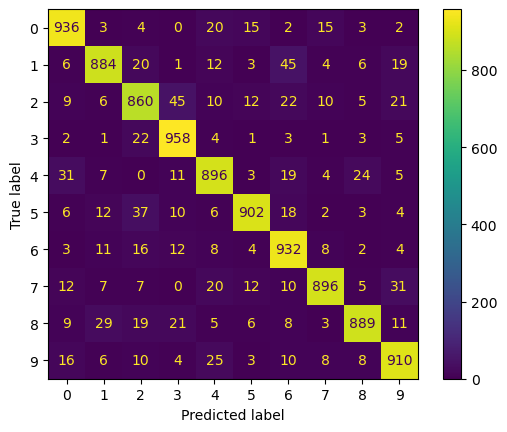

In [73]:
predicted_classes = model.predict(X_test)

true_labels = np.argmax(Y_test,axis=1)

predicted_labels = np.argmax(predicted_classes,axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))
print("Weighted Precision: " + str(precision_score(true_labels, predicted_labels, average='weighted')))
print("Weighted Recall: " + str(recall_score(true_labels, predicted_labels, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(true_labels, predicted_labels, average='weighted')))

In [55]:
#chosen_idx = np.argwhere(np.array(best_heights) == lh_select)

#ab_lws = []
#for idx in chosen_idx:
#    ab_lws.append(best_widths[idx[0]])

#lws_unique, lws_counts = np.unique(ab_lws, return_counts=True)
#lws_data = dict(zip(lws_unique, lws_counts))

#lw_x_values = list(lws_data.keys())
#lw_y_values = list(lws_data.values())
#lw_x_values = [str(r) for r in lw_x_values]
  
#fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
#plt.bar(lw_x_values, lw_y_values, color ='maroon', 
#        width = 0.1)

 
#plt.xlabel("Heights")
#plt.ylabel("# of instances")
#plt.title("Layer Heights in Trials")
#plt.xticks(lw_x_values,rotation=45)
#plt.show()

#lw_mode = statistics.mode(sorted(ab_lws))
#print(lw_mode)

In [57]:
score = best_model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.9838 - accuracy: 0.2856
Test accuracy: 0.2856000065803528


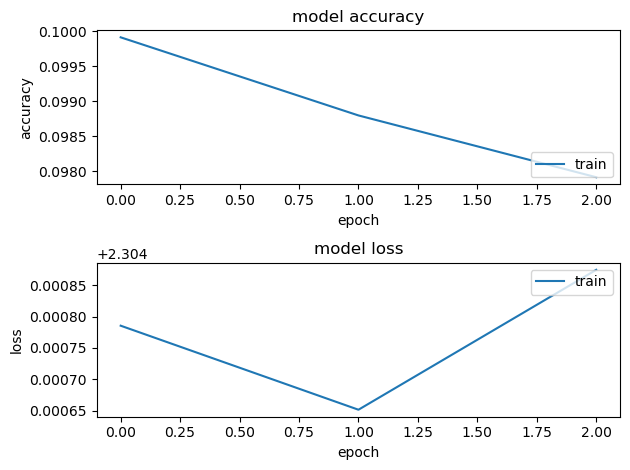

In [10]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(best_histories[idx].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(best_histories[idx].history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [18]:
results = best_model.predict(X_test)

313/313 [==============================] - 1s 4ms/step


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.7894
Weighted Precision: 0.7933314405941213
Weighted Recall: 0.7894
Weighted F1 Score: 0.789827671440989


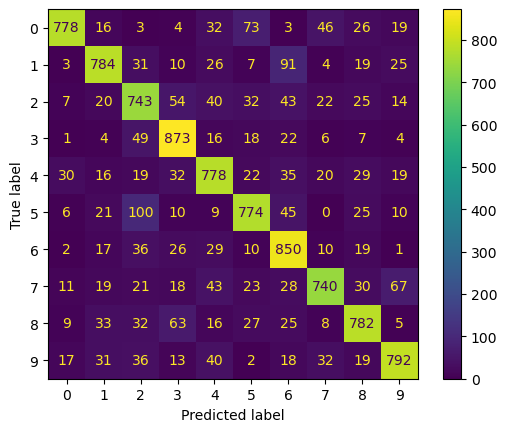

In [19]:
predicted_classes = best_model.predict(X_test)

true_labels = np.argmax(Y_test,axis=1)

predicted_labels = np.argmax(predicted_classes,axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))
print("Weighted Precision: " + str(precision_score(true_labels, predicted_labels, average='weighted')))
print("Weighted Recall: " + str(recall_score(true_labels, predicted_labels, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(true_labels, predicted_labels, average='weighted')))

In [20]:
y_pred_ensemble = np.zeros((Y_test.shape))

#print(y_pred_ensemble.shape)

#count = 0
#for i in range(y_pred_ensemble.shape[0])
for model in models:
    y_pred_ensemble += model.predict(X_test)

y_pred_ensemble /= len(models)
    

313/313 [==============================] - 2s 5ms/step


### Extensions to the project
1. Alter parameters of layers (Number of perceptrons, more Convolution and pooling layers) 
2. Preprocessing on the data (filter?)
3. Ensemble learning
4. Utilize Graphcore IPU

In [21]:
#print(y_pred_ensemble)
#print(np.argmax(y_pred_ensemble, axis=1))
ensemble_pred = np.argmax(y_pred_ensemble, axis=1)

Accuracy: 0.8404
Weighted Precision: 0.8431929486961726
Weighted Recall: 0.8404
Weighted F1 Score: 0.8405224380378155


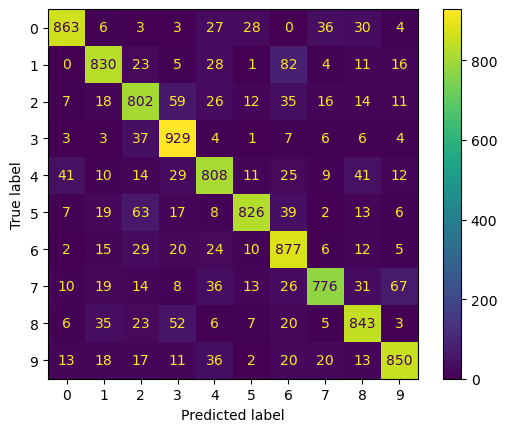

In [22]:
#predicted_classes = ensemble_pred

true_labels = np.argmax(Y_test,axis=1)

predicted_labels = ensemble_pred

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))
print("Weighted Precision: " + str(precision_score(true_labels, predicted_labels, average='weighted')))
print("Weighted Recall: " + str(recall_score(true_labels, predicted_labels, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(true_labels, predicted_labels, average='weighted')))